In [1]:
! pip install lime
! pip install captum
! pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=97c1e0760e02c7ecf00c94a4c984497bcc08cbb362e7a675c867d4bba206fa83
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=abc171faf2df967bc6014b1c103304062b68269139041aa3c95b88a8ec5bde35
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [2]:
from medmnist import PathMNIST

import numpy as np
import cv2


import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F

import torch.nn as nn

from PIL import Image
from lime import lime_image
from captum.attr import GradientShap, visualization as viz
from captum.attr import GuidedGradCam

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
def load_model(model_path, device):
    model = torch.load(model_path, map_location=device)
    model.eval()
    return model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class AdvancedModel(nn.Module):
    def __init__(self, num_classes=9, input_shape=(3, 64, 64)):
        super(AdvancedModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)
            # print(f"Flattened size: {flattened_size}")

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class TransferLearningModelDenseNet(nn.Module):
    def __init__(self, num_classes=9, pretrained=True):
        super(TransferLearningModelDenseNet, self).__init__()

        self.base_model = models.densenet121(pretrained=pretrained)

        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


class TransferLearningModelSqueezenet(nn.Module):
    def __init__(self, num_classes=9, pretrained=True):
        super(TransferLearningModelSqueezenet, self).__init__()

        self.base_model = models.squeezenet1_1(pretrained=pretrained)

        self.base_model.classifier = nn.Sequential(
            nn.Conv2d(512, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.num_classes = num_classes

    def forward(self, x):
        return self.base_model(x)


class TransferLearningModelResNet50(nn.Module):
    def __init__(self, num_classes=9, pretrained=True):
        super(TransferLearningModelResNet50, self).__init__()

        self.base_model = models.resnet50(pretrained=pretrained)

        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

class TransferLearningModel(nn.Module):
    def __init__(self, num_classes=9, pretrained=True):
        super(TransferLearningModel, self).__init__()

        self.base_model = models.resnet18(pretrained=pretrained)

        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

class TransferLearningModelMobileNetV2(nn.Module):
    def __init__(self, num_classes=9, pretrained=True):
        super(TransferLearningModelMobileNetV2, self).__init__()

        self.base_model = models.mobilenet_v2(pretrained=pretrained)

        num_features = self.base_model.classifier[1].in_features
        self.base_model.classifier[1] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

In [6]:
model = TransferLearningModelDenseNet(num_classes=9)
model.load_state_dict(torch.load("/content/DenseNet.pth", map_location=device, weights_only=True))
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 81.9MB/s]


TransferLearningModelDenseNet(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96

In [7]:
transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [8]:
test_dataset = PathMNIST(
    split="test", size=64, transform=transform_val_test, download=True,
    target_transform=lambda x: torch.tensor(x, dtype=torch.long).squeeze()
)

100%|██████████| 1.07G/1.07G [00:33<00:00, 31.8MB/s]


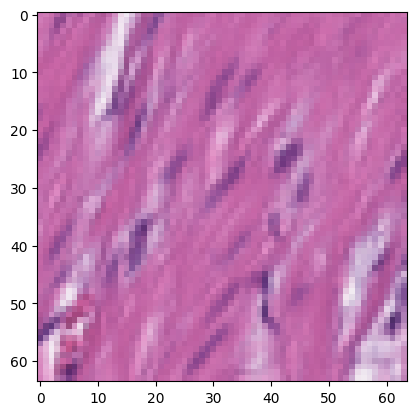

In [9]:
img_arr = test_dataset.imgs[150]
plt.imshow(img_arr);

# LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

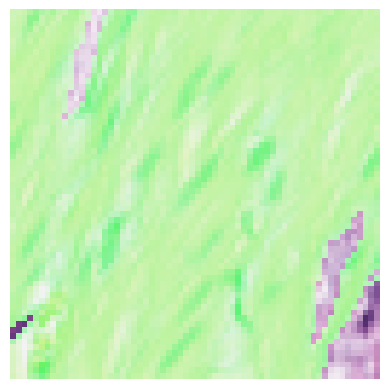

In [10]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from lime.lime_image import LimeImageExplainer

def predict_proba(images):
    images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
    with torch.no_grad():
        logits = model(images)
        return torch.nn.functional.softmax(logits, dim=1).numpy()

explainer = LimeImageExplainer()
segmentation_fn = SegmentationAlgorithm("quickshift", kernel_size=5, max_dist=10, ratio=0.9)
explanation = explainer.explain_instance(
    image=np.array(img_arr).astype(np.float32) / 255.0,  # Scale to [0, 1],
    classifier_fn=predict_proba,
    segmentation_fn=segmentation_fn
)

lime_image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=5
)

# Ensure LIME image values are normalized for saving
lime_image = (lime_image * 255).astype(np.uint8)

# Save the LIME result
lime_result = Image.fromarray(lime_image)
plt.imshow(lime_result)
plt.axis('off');

# Saliency map

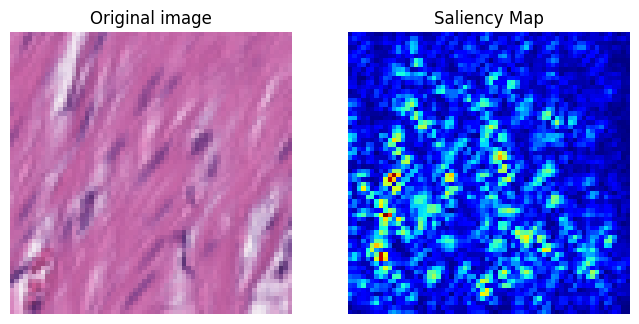

In [11]:
def compute_saliency_map(model, img, class_idx):

    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2)
    img_tensor.requires_grad = True

    model.eval()
    logits = model(img_tensor)
    loss = logits[0, class_idx]

    loss.backward()

    grads = img_tensor.grad.data.abs()
    saliency = grads.max(dim=1)[0].squeeze().cpu().numpy()

    return saliency

with torch.no_grad():
    logits = model(torch.tensor(img_arr, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2))
    class_idx = torch.argmax(logits, dim=1).item()

saliency_map = compute_saliency_map(model, img_arr, class_idx)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original image")
plt.imshow(img_arr)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap="jet")
plt.axis("off")
plt.show()

# Grad-CAM

In [12]:
# for name, module in model.named_modules():
#     print(name, "->", module)

In [13]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(f"Found Conv2D layer: {name}")

Found Conv2D layer: base_model.features.conv0
Found Conv2D layer: base_model.features.denseblock1.denselayer1.conv1
Found Conv2D layer: base_model.features.denseblock1.denselayer1.conv2
Found Conv2D layer: base_model.features.denseblock1.denselayer2.conv1
Found Conv2D layer: base_model.features.denseblock1.denselayer2.conv2
Found Conv2D layer: base_model.features.denseblock1.denselayer3.conv1
Found Conv2D layer: base_model.features.denseblock1.denselayer3.conv2
Found Conv2D layer: base_model.features.denseblock1.denselayer4.conv1
Found Conv2D layer: base_model.features.denseblock1.denselayer4.conv2
Found Conv2D layer: base_model.features.denseblock1.denselayer5.conv1
Found Conv2D layer: base_model.features.denseblock1.denselayer5.conv2
Found Conv2D layer: base_model.features.denseblock1.denselayer6.conv1
Found Conv2D layer: base_model.features.denseblock1.denselayer6.conv2
Found Conv2D layer: base_model.features.transition1.conv
Found Conv2D layer: base_model.features.denseblock2.dense

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


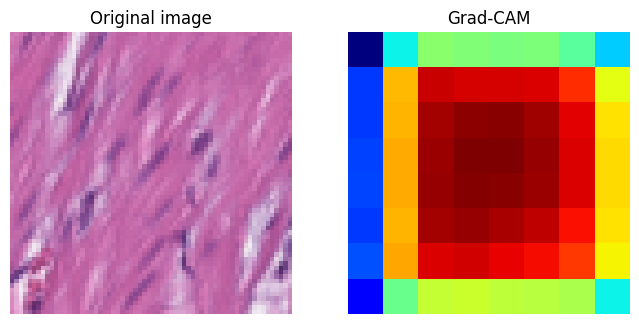

In [14]:
def grad_cam(model, img, target_layer):

    model.eval()

    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2)
    img_tensor.requires_grad = True

    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    logits = model(img_tensor)
    class_idx = torch.argmax(logits, dim=1).item()
    loss = logits[0, class_idx]

    loss.backward()

    activation = activations[0].detach()
    gradient = gradients[0].detach()

    pooled_gradients = torch.mean(gradient, dim=(0, 2, 3))

    for i in range(pooled_gradients.shape[0]):
        activation[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.sum(activation, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap = heatmap / torch.max(heatmap)

    handle_forward.remove()
    handle_backward.remove()

    return heatmap.cpu().numpy()


# target_layer = model.base_model.layer2[2].conv1
# target_layer = model.base_model.features[4].squeeze

target_layer = model.base_model.features.denseblock2.denselayer12.conv2
heatmap = grad_cam(model, img_arr, target_layer)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original image")
plt.imshow(img_arr)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(heatmap, cmap="jet")
plt.axis("off")
plt.show()

In [15]:
def overlay_heatmap(img, heatmap):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    colormap = cm.get_cmap('jet')
    heatmap_colored = colormap(heatmap_resized)[:, :, :3]

    img_normalized = img.astype('float32') / 255.0

    heatmap_colored = heatmap_colored.astype('float32')

    overlay = cv2.addWeighted(img_normalized, 0.6, heatmap_colored, 0.4, 0)

    return overlay, heatmap_resized

<ipython-input-15-10261a338612>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet')


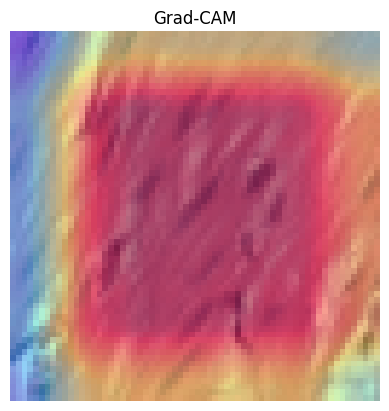

In [16]:
result, ob = overlay_heatmap(img_arr, heatmap)
plt.imshow(result)
plt.axis("off")
plt.title("Grad-CAM")
plt.show()

# Gradient Shap

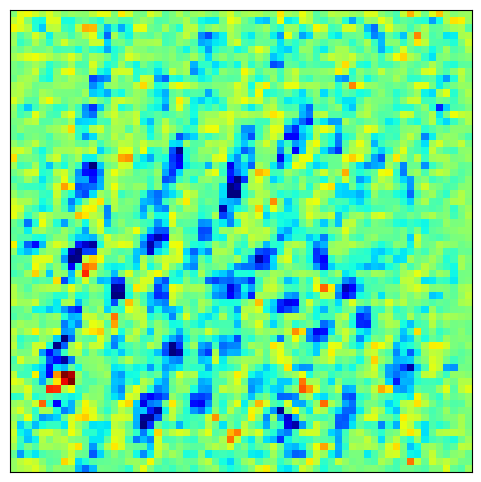

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [18]:
gradient_shap = GradientShap(model)

img_tensor = torch.tensor(img_arr).float().permute(2, 0, 1).unsqueeze(0)

# img_tensor = torch.tensor(img_arr).float().unsqueeze(0)
baseline = torch.zeros_like(img_tensor)

grads_shap_attr = gradient_shap.attribute(
    img_tensor, baselines=baseline, target=torch.argmax(model(img_tensor)).item()
)

viz.visualize_image_attr(
    grads_shap_attr.squeeze(0).permute(1, 2, 0).detach().numpy(),
    sign="all", cmap = 'jet'
)